In [21]:
import pandas as pd
pd.set_option('max_colwidth', 10000)
pd.set_option('display.max_columns', 100)
import numpy as np
import spacy
import contextualSpellCheck
import nltk
import re
import ftfy
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import pyLDAvis
import pyLDAvis.sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [129]:
df = pd.read_csv("data_compiled_raw_per_bar.csv").iloc[:,1:]

In [3]:
# Spell check ------- done manually, maybe will try to see if word2vec can do this (or can do regex to at least get in$ to ing)
# FTFY package converting ain't into aingt ----- this matter is resolved
# slang (pronoun) dictionary - Jay-Z, Ms. Jackson, (consider dropping named entities)
# named entity recognition
# Cosine similarity to remove (almost) duplicates on Chorus
# Remove verbs, keep adjectives and nouns
# Drop immortal technique + 4487 Common? or spanish
# DO BIGRAMS & hyphens

### Data cleaning and setup

In [131]:
len(df)

168105

In [133]:
nlp = spacy.load('en_core_web_sm')
spacyd = list(nlp.pipe(df.lyrics))
pronouns = spacyd.copy()

In [134]:
len(df)

168105

In [7]:
slangs = pd.read_csv("lyrics_all/slang_dict.csv")
slang_norm = dict(zip(slangs.dropna(axis=0, subset=['revision']).token,slangs.dropna(axis=0, subset=['revision']).revision))

slang_norm

{'cah': 'because',
 'jolies': 'jolie',
 "d'ussé": 'alcohol',
 'packard': 'electronics',
 's600': 'luxcar',
 'trickin': 'tricking',
 'havenotz': 'havenots',
 'steamin': 'steaming',
 'shotta': 'shooter',
 'papparazi': 'paparazzi',
 'draco': 'rifle',
 'doggfather': 'snoop',
 'fawcett': 'Fuck it',
 'bitin': 'biting',
 "y'see": 'You see',
 'moms': 'mama',
 'wettin': 'wetting',
 'payin': 'paying',
 'neg': 'negative',
 'cashin': 'cashing',
 'bmw': 'luxcar',
 'delayin': 'delaying',
 'ohh,\\(breathing\\),what': 'oh',
 'sendin': 'sending',
 "wooo!\\),ain't": 'woah',
 'stealin': 'stealing',
 'marlin': 'marling',
 'surfin': 'surfing',
 '9/11': 'terror',
 'englewood': 'california',
 'mdma': 'drug',
 'mc.,i': 'emcee',
 'saaab': 'saab',
 'seekin': 'seeking',
 "vuitton'd": 'luxapparel',
 'optimos': 'optimus',
 'sumthin': 'something',
 'nigga,\\(put': 'nigga',
 'grandmas': 'grandparents',
 'witcho': 'With your',
 'astaghfirullah': 'astagfirullah',
 'coachin': 'coaching',
 'wanna': 'Want to',
 'mothafuc

### Preprocessing pipeline

In [140]:
def ftfythx (x):
    if type(x) == str():
        return ftfy.fix_text(x)
    else:
        return x

def regex_norm(string):
#     re.sub(string, slang_norm[key], string)
    for key, value in slang_norm.items():
        string = re.sub(r'\b' + key + r'\b', value, string)
    return string
    
def cleanup (df, dfcolumn):

    df["temp1"] = dfcolumn.apply(lambda x: ftfythx(x))
    df.dropna(subset=["temp1"], axis=0, inplace=True)
    
    df["temp1"] = df.temp1.replace({',':' ', "'":' '}, regex=True).str.strip().apply(lambda x: re.sub('^\\[(.*?)\\]', '', x)) #remove [verse]
    df["temp1"] = df.temp1.apply(lambda x: re.sub("in'$", 'ing', x)) #revise in' to ing (e.g. shootin' to shooting)
    df["temp2"] = df.temp1.str.extract("(\\w*-\\w*)") #grab hyphenated words to another column
    df["temp1"] = df.temp1.str.replace("(\\w*-\\w*)","") #remove hyphenated words from original column
#     df["temp1"] = df.temp1.str.lower().apply(regex_norm) #manual normalization with slang dictionary
        
    nlp = spacy.load('en_core_web_sm')
    spacyd = list(nlp.pipe(df.temp1))
    spacy_clean = ([" ".join([w.lemma_ for w in doc if not(w.is_stop and not w.is_punct and not w.like_num\
#                                                                    and not w.pos_ == "VERB")])\
                                                          )])
                                                                    for doc in spacyd])
    df["tokens"] = spacy_clean
    df.tokens.str.cat(df.temp2.str, sep=" ")
    df.drop(columns=["temp1","temp2"], axis=1, inplace=True)
#     spacy_propn = ([" ".join([w.lemma_.lower() for w in doc if (w.pos_ == "PROPN")] for doc in spacyd)])
#     df["placeholder2"] = spacy_propn


In [141]:
cleanup(df, df.lyrics)

/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_10126/276301612.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df["temp1"] = df.temp1.str.replace("(\\w*-\\w*)","") #remove hyphenated words from original column


KeyboardInterrupt: 

In [ ]:
df.loc[5000:5010]

In [142]:
def cleanup_aggressive (df, dfcolumn):

    df["temp1"] = dfcolumn.apply(lambda x: ftfythx(x))
    df.dropna(subset=["temp1"], axis=0, inplace=True)
    
    df["temp1"] = df.temp1.replace({',':' ', "'":' '}, regex=True).str.strip().apply(lambda x: re.sub('^\\[(.*?)\\]', '', x)) #remove [verse]
    df["temp1"] = df.temp1.apply(lambda x: re.sub("in'$", 'ing', x)) #revise in' to ing (e.g. shootin' to shooting)
    df["temp2"] = df.temp1.str.extract("(\\w*-\\w*)") #grab hyphenated words to another column
    df["temp1"] = df.temp1.str.replace("(\\w*-\\w*)","") #remove hyphenated words from original column
#     df["temp1"] = df.temp1.str.lower().apply(regex_norm) #manual normalization with slang dictionary
        
    nlp = spacy.load('en_core_web_sm')
    spacyd = list(nlp.pipe(df.temp1))
    spacy_clean = ([" ".join([w.lemma_ for w in doc if not(w.is_stop and not w.is_punct and not w.like_num\
                                                                   and not w.pos_ != "VERB" and not w.pos_ !="NOUN"\
                                                          and not w.pos_ != "PROPN")])\
#                                                           )])
                                                                    for doc in spacyd])
    df["tokens"] = spacy_clean
    df.tokens.str.cat(df.temp2.str, sep=" ")
    df.drop(columns=["temp1","temp2"], axis=1, inplace=True)
#     spacy_propn = ([" ".join([w.lemma_.lower() for w in doc if (w.pos_ == "PROPN")] for doc in spacyd)])
#     df["placeholder2"] = spacy_propn

In [143]:
dfagg = df.copy()
cleanup_aggressive(dfagg,dfagg.lyrics)

/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_10126/1106516026.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df["temp1"] = df.temp1.str.replace("(\\w*-\\w*)","") #remove hyphenated words from original column
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/pandas/core/strings/accessor.py:393: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  others = list(others)  # ensure iterators do not get read twice etc


In [231]:
dfagg.shape

(168105, 3)

In [232]:
dfagg.drop_duplicates(subset=["lyrics"], inplace=True)

In [233]:
dfagg.shape

(136906, 3)

### LDA with CountVectorizer

In [145]:
ex_label = [e[:30]+"..." for e in df.lyrics.values]

In [146]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', max_df=0.05, min_df=0.0001, max_features = 500, token_pattern = r'\b[a-z\-A-Z]{3,}\b')
dt = cv.fit_transform(df.tokens.values)
df_dtf = pd.DataFrame(dt.toarray(), index=ex_label, columns=cv.get_feature_names())

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=20, random_state=0)
lda.fit(dt)

AttributeError: 'DataFrame' object has no attribute 'tokens'

In [147]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, dt, cv)

NotFittedError: Vocabulary not fitted or provided

### LDA with TfidfVectorizer

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_df=0.05, min_df=0.0001, max_features=1000, token_pattern = r'\b[a-zA-Z]{3,}\b')
dt_idf = tfidf.fit_transform(df.tokens.values)
df_idf = pd.DataFrame(dt_idf.toarray(), index=ex_label, columns=tfidf.get_feature_names())

lda2 = LatentDirichletAllocation(n_components=20, random_state=0)
lda2.fit(dt_idf)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


LatentDirichletAllocation(n_components=20, random_state=0)

In [24]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda2, dt_idf, tfidf)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.009747 -0.002899       1        1  19.679415
9     -0.003779 -0.002586       2        1  18.396145
5     -0.028134 -0.020397       3        1  14.617366
7      0.047394  0.000795       4        1   8.974813
16    -0.000779 -0.142509       5        1   2.924833
11     0.095356 -0.076750       6        1   2.798579
8     -0.028972 -0.039222       7        1   2.703208
2     -0.020950 -0.041969       8        1   2.598492
0     -0.197732  0.034181       9        1   2.544717
17     0.201398 -0.051780      10        1   2.463940
18     0.034205  0.013196      11        1   2.385415
10     0.001838  0.150815      12        1   2.383569
19    -0.116151 -0.052736      13        1   2.336887
13     0.043111  0.023762      14        1   2.306979
3     -0.041505  0.269636      15        1   2.249541
12     0.014877  0.006681      16        1   2.226240
1     -0.167259 -0.071001      17        1   2.180262
6     -0.006993 -0.086911      18        1   2.150649
4      0.023791  0.013903      19        1   2.065721
15     0.160031  0.075792      20        1   2.013228, topic_info=             Term        Freq       Total Category  logprob  loglift
888          thug  136.000000  136.000000  Default  30.0000  30.0000
566  notoriousbig   94.000000   94.000000  Default  29.0000  29.0000
932         verse   77.000000   77.000000  Default  28.0000  28.0000
941          wait  110.000000  110.000000  Default  27.0000  27.0000
13        alright   89.000000   89.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
128         check   10.033657  104.820117  Topic20  -4.2881   1.5591
348          gang   10.221449  121.351154  Topic20  -4.2695   1.4312
449          king    7.825698   61.457279  Topic20  -4.5366   1.8445
67          blunt    6.969023   51.854916  Topic20  -4.6525   1.8985
504     marijuana    7.362178  107.938207  Topic20  -4.5976   1.2202

[865 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.148827    act
0         2  0.201980    act
0         3  0.170088    act
0         4  0.095675    act
0         6  0.021261    act
...     ...       ...    ...
997      20  0.510259   york
998       1  0.113483  youth
998       2  0.226966  youth
998       3  0.283707  youth
998       5  0.340449  youth

[5372 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 10, 6, 8, 17, 12, 9, 3, 1, 18, 19, 11, 20, 14, 4, 13, 2, 7, 5, 16])

### EDA of the CV vectors

In [283]:
cv = CountVectorizer(stop_words='english', token_pattern = r'\b[a-zA-Z]{3,}\b') #removes tokens with less than 3 letters
docterm_all = cv.fit_transform(df.temp1.values)
dtf_all = pd.DataFrame(docterm_all.toarray(), index=ex_label_agg, columns=cv.get_feature_names())

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

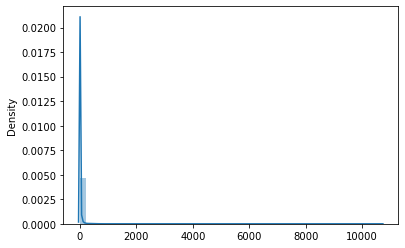

In [285]:
corpus_count = dtf_all.sum(axis=0)
sns.distplot(corpus_count, kde=True)

In [288]:
corpus_count.sort_values(ascending=False)[:20].sum()/corpus_count.sum()

0.15865569052212788

In [293]:
len(corpus_count)

32061

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

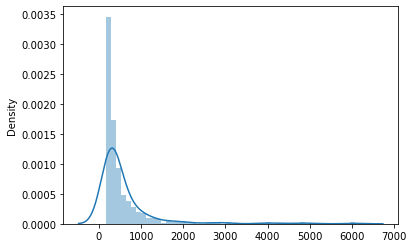

In [307]:
corpus_count_agg = df_dtfagg.sum(axis=0)
sns.distplot(corpus_count_agg, kde=True)

In [308]:
corpus_count_agg.sort_values(ascending=False)[:20].sum()/corpus_count_agg.sum()

0.252782003726432

In [305]:
len(corpus_count_agg)/len(corpus_count)

0.8074919684351705

In [319]:
dfagg[dfagg.artist=="Jay-z"][60:90]

,artist,lyrics,tokens
79532,Jay-z,Just so you can watch me bleed,just so you can watch I bleed
79533,Jay-z,"And I still don't know why, why I love you so much, yeah",and I still don t know why why I love you so much yeah
79534,Jay-z,And you play this game in spite to drive me insane,and you play this game in spite to drive I insane
79535,Jay-z,I got it tattooed on my sleeve,I get it tattoo on my sleeve
79536,Jay-z,Forever in ink with guess whose name,forever in ink with guess whose name
79537,Jay-z,"But I still don't know why, why our love is so much",but I still don t know why why our love be so much
79546,Jay-z,"Who wants that perfect love story anyway, anyway?",who want that perfect love story anyway anyway ?
79547,Jay-z,"Cliché, cliché, cliché, cliché",Cliché cliché cliché cliché
79548,Jay-z,"Who wants that hero love that saves the day, anyway?",who want that hero love that save the day anyway ?
79550,Jay-z,"What about the bad guy goes good, yeah?",what about the bad guy go good yeah ?


### NMF

In [29]:
def make_topics(corpus, vectorizer, topic_modeler, print_n_words=15):
    """A very simple pipeline."""
    
#     # Apply preprocessor, vectorizer, and topic modeler.
#     if preprocessor is not None:
#         docs = docs.apply(preprocessor)
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(corpus)
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i].upper() for i in topic.argsort()[:-print_n_words-1:-1]]
        print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
    return doc_topic_vectors

In [30]:
cv_nmf = CountVectorizer(stop_words='english', max_df=0.2, min_df=2, token_pattern = r'\b[a-zA-Z]{3,}\b') #removes tokens with less than 3 letters
dt_nmf = cv.fit_transform(df.tokens.values)

tfidf_nmf = TfidfVectorizer(stop_words='english', max_df=0.2, min_df=2, token_pattern = r'\b[a-zA-Z]{3,}\b')
dt_idf_nmf = tfidf.fit_transform(df.tokens.values)

corpus1 = np.array(df.tokens)
nmf = NMF(6)
make_topics(corpus1, cv_nmf, nmf, print_n_words=20)


/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic 0:
 TELL, TIME, FEEL, LET, LOOK, LIFE, THINK, SAY, TRY, BOY, DAY, WAY, GOD, LIVE, TALK, RUN, BULLSHIT, LEAVE, HIT, RIGHT 

Topic 1:
 COOL, HEY, THROWDOWN, NEED, LOOK, SUNNY, SHORTIE, KITTY, BLUE, CAT, PLAY, DIAMOND, PEANUT, BABY, YES, MADISON, NEW, RICH, SHADE, SLEAZY 

Topic 2:
 MAN, FUCKING, THANK, KILL, RIGHT, BLACK, MOTHERFUCKE, SHOUT, REAL, DONALD, BIG, WAY, DAMN, GOT, BEAT, FAMILY, BELIEVE, FLAVOR, THING, CLASSIC 

Topic 3:
 MONEY, HOE, FETTI, MARIJUANA, DENIRO, COOCHIE, DRUG, ASS, LET, DAMN, CHASE, PISTOL, NIKE, NEED, SET, WORD, BREAK, BIG, LIVE, DOLLAR 

Topic 4:
 LOVE, LET, RIGHT, WAY, GIRL, FEEL, BABY, DAY, WORD, HATE, GOT, HEART, THING, NIGHT, HARD, THANK, THINK, PEOPLE, LIFE, FALL 

Topic 5:
 MARY, MARIJUANA, THANG, ASS, TIME, HEAR, DOOR, HAPPY, HEAD, NEED, BABY, FEEL, START, STAND, LOVE, MAKE, TRUE, HOE, DAMN, SAY 



/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[1.29899805e-01, 0.00000000e+00, 0.00000000e+00, 1.41541569e-02,
        9.86790671e-03, 0.00000000e+00],
       [5.62691818e-02, 1.01910009e-02, 0.00000000e+00, 0.00000000e+00,
        1.88124916e-03, 1.73950960e-03],
       [8.22633690e-02, 3.21908371e-02, 0.00000000e+00, 1.34940900e-02,
        1.87406121e-01, 0.00000000e+00],
       ...,
       [2.59150132e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.12770901e-02, 2.02477515e-03],
       [7.70749038e-02, 8.96459300e-02, 0.00000000e+00, 0.00000000e+00,
        7.12967956e-04, 0.00000000e+00],
       [4.79623246e-02, 1.87116720e-04, 0.00000000e+00, 0.00000000e+00,
        2.16407339e-02, 3.62077547e-03]])

### Rinse & Repeat - LDA+NMF with aggressively reduced bag of words

In [266]:
ex_label_agg = [e[:30]+"..." for e in dfagg.lyrics.values]

In [306]:
cvagg = CountVectorizer(stop_words='english', max_df=0.05, max_features=500, token_pattern = r'\b[a-zA-Z]{3,}\b') #removes tokens with less than 3 letters
dtagg = cvagg.fit_transform(dfagg.tokens.values)
df_dtfagg = pd.DataFrame(dtagg.toarray(), index=ex_label_agg, columns=cvagg.get_feature_names())
ldaagg = LatentDirichletAllocation(n_components=6, random_state=0)
ldaagg.fit(dt)
pyLDAvis.sklearn.prepare(ldaagg, dtagg, cvagg)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.037881  0.015042       1        1  18.960533
2      0.183990 -0.106258       2        1  17.842790
1     -0.116340 -0.106676       3        1  17.096171
4     -0.029170  0.008713       4        1  15.772093
0      0.053294  0.171371       5        1  15.529480
3     -0.129655  0.017808       6        1  14.798933, topic_info=       Term         Freq        Total Category  logprob  loglift
172    gold  1876.000000  1876.000000  Default  30.0000  30.0000
10     away  1648.000000  1648.000000  Default  29.0000  29.0000
446   touch  1143.000000  1143.000000  Default  28.0000  28.0000
169   glock  1543.000000  1543.000000  Default  27.0000  27.0000
398    soul  1111.000000  1111.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
272  moment   295.594143   701.618366   Topic6  -4.9866   1.0462
179    grow   268.701365   550.226188   Topic6  -5.0820   1.1939
223     kid   327.791825  1005.552632   Topic6  -4.8832   0.7897
389    slow   301.829020  1046.272660   Topic6  -4.9658   0.6675
205    hood   273.200086   793.052082   Topic6  -5.0654   0.8449

[280 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.058575    act
0         2  0.146000    act
0         3  0.040216    act
0         4  0.155617    act
0         5  0.424012    act
...     ...       ...    ...
498       6  0.228283    yes
499       1  0.022727  young
499       3  0.871192  young
499       4  0.005050  young
499       6  0.098483  young

[1271 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 5, 1, 4])

In [269]:
df_dtfagg

,act,ain,air,album,alive,alright,america,arm,ask,ass,away,baby,bad,bag,ball,bang,bar,bear,beat,bed,beef,believe,bet,big,bitch,black,blame,blast,blind,block,blood,blow,blue,blunt,body,bottle,bout,box,boy,brain,break,bring,brother,buck,build,bullet,burn,business,bust,buy,...,tree,trick,trip,true,trust,truth,try,tryin,tryna,turn,type,uhh,understand,use,verse,wait,wake,walk,wall,wanna,want,war,wasn,watch,water,way,wear,weed,week,west,whip,white,win,window,wish,wit,woman,wonder,woo,word,work,world,worry,wouldn,write,wrong,yeah,year,yes,young
We sell crack to our own out t...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
We smell the musk of the dusk ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"We go through episodes too, li...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Work 'til we break our back an...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
"Just to get by, just to get by...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Fuck nerdcore, fuck backpack...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"Fuck rap cool, I make cool rap...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I make music for wack blacks t...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"In fact, I swear the track I l...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [150]:
tfidfagg = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=0.0001, max_features=500, token_pattern = r'\b[a-zA-Z]{3,}\b')
dt_idfagg = tfidfagg.fit_transform(dfagg.tokens.values)
df_idfagg = pd.DataFrame(dt_idfagg.toarray(), index=ex_label, columns=tfidfagg.get_feature_names())
lda_idfagg = LatentDirichletAllocation(n_components=6, random_state=0)
lda_idfagg.fit(dt_idfagg)
pyLDAvis.sklearn.prepare(lda_idfagg, dt_idfagg, tfidfagg)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.152345 -0.203188       1        1  17.124022
2     -0.089580  0.209313       2        1  17.048212
0     -0.030298  0.231051       3        1  16.905519
4     -0.026992 -0.196289       4        1  16.579853
1      0.290898  0.066902       5        1  16.237430
3     -0.296373 -0.107789       6        1  16.104964, topic_info=       Term         Freq        Total Category  logprob  loglift
25    bitch  2506.000000  2506.000000  Default  30.0000  30.0000
496    yeah  2228.000000  2228.000000  Default  29.0000  29.0000
72     come  2099.000000  2099.000000  Default  28.0000  28.0000
1       ain  2717.000000  2717.000000  Default  27.0000  27.0000
287   nigga  4280.000000  4280.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
482     win   496.832285   606.504286   Topic6  -4.2586   1.6266
239    like  2115.176566  5366.495731   Topic6  -2.8099   0.8950
171     gon   530.563355  1190.661873   Topic6  -4.1929   1.0177
193    hell   357.903980   428.859945   Topic6  -4.5865   1.6452
59   change   353.915969   492.473162   Topic6  -4.5978   1.4957

[270 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         3  0.998866    act
1         1  0.006257    ain
1         2  0.001840    ain
1         3  0.148692    ain
1         5  0.842836    ain
...     ...       ...    ...
491       6  0.806405  world
494       4  0.997885  write
495       1  0.998871  wrong
496       2  0.999574   yeah
499       5  0.997797  young

[343 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 1, 5, 2, 4])

In [234]:
cv_nmfagg = CountVectorizer(stop_words='english', max_df=0.05, max_features=500, token_pattern = r'\b[a-zA-Z]{3,}\b') #removes tokens with less than 3 letters
dt_nmfagg = cv_nmfagg.fit_transform(dfagg.tokens)
corpus1agg = np.array(dfagg.tokens)
nmfagg = NMF(6)
make_topics(corpus1agg, cv_nmfagg, nmfagg, print_n_words=10)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic 0:
 SHIT, MAN, MAKE, SAY, YEAH, COME, REAL, GON, TALK, RIGHT 

Topic 1:
 KNOW, SAY, YEAH, MAN, LET, LOVE, COME, TIME, WANNA, TELL 

Topic 2:
 DON, WANNA, WANT, CAUSE, NEED, MAKE, TELL, THINK, STOP, NIGGAS 

Topic 3:
 JUST, MAKE, WANNA, COME, LET, LOVE, SAY, WANT, YEAH, TIME 

Topic 4:
 FUCK, BITCH, SAY, MAN, TELL, NIGGAS, COME, MONEY, LET, WANT 

Topic 5:
 AIN, CAUSE, BITCH, LOVE, SAY, GON, TELL, TIME, MAKE, LIFE 



/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[0.00201352, 0.00140224, 0.00036976, 0.00147759, 0.00071894,
        0.00179969],
       [0.00027975, 0.00025837, 0.00014607, 0.00014425, 0.0001102 ,
        0.00026141],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       ...,
       [0.01039648, 0.        , 0.0057977 , 0.01397215, 0.        ,
        0.00758865],
       [0.00081299, 0.00119902, 0.00084928, 0.00190849, 0.00061827,
        0.00365904],
       [0.00119887, 0.00028414, 0.00122178, 0.00128915, 0.00103193,
        0.00103558]])

In [152]:
tfidf_nmfagg = TfidfVectorizer(stop_words='english', max_df=0.2, min_df=2, max_features=500, token_pattern = r'\b[a-zA-Z]{3,}\b')
dt_idf_nmfagg = tfidf_nmfagg.fit_transform(dfagg.tokens.values)
corpus2agg = np.array(dfagg.tokens)
make_topics(corpus2agg, cv_nmfagg, nmfagg, print_n_words=10)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic 0:
 LIKE, FEEL, LOOK, BITCH, LIFE, MAKE, ACT, LIVE, MAN, COME 

Topic 1:
 NIGGA, MAN, REAL, ASS, YOUNG, COME, KILL, TELL, WANT, GON 

Topic 2:
 KNOW, SAY, LORD, MAN, LET, LOVE, WANNA, COME, TIME, THING 

Topic 3:
 DON, WANNA, WANT, CAUSE, NEED, TELL, STOP, NIGGAS, LET, CARE 

Topic 4:
 FUCK, SHIT, AIN, YEAH, BITCH, SAY, MAN, CAUSE, MAKE, LOVE 

Topic 5:
 JUST, MAKE, WANNA, LOVE, LET, LITTLE, WANT, LIFE, COME, CAUSE 



/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[4.96720570e-04, 2.15350289e-03, 8.51585792e-04, 1.32649375e-04,
        1.76227046e-03, 1.40301409e-03],
       [2.50553994e-04, 7.48679637e-04, 1.10783625e-04, 4.91507324e-05,
        1.02611769e-04, 1.75114393e-04],
       [7.07911453e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [7.47492602e-04, 1.13639009e-04, 0.00000000e+00, 4.06149176e-04,
        2.43247644e-04, 7.78977805e-04],
       [3.22770486e-04, 2.50793902e-04, 1.80702594e-04, 3.69866505e-04,
        1.23390126e-03, 7.27060135e-04]])

### CorEx - no anchor, original df

In [ ]:
!pip install corextopic
!pip install networkx

In [35]:
import scipy.sparse as ss
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

In [36]:
words = list(np.asarray(cv_nmf.get_feature_names()))

In [37]:
ce_model = ct.Corex(n_hidden=6, words=words, seed=1)
ce_model.fit(dt_nmf, words=words, docs=df.tokens)

In [41]:
# Print all topics from the CorEx topic model
topics = ce_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

TypeError: sequence item 0: expected str instance, numpy.int64 found

In [ ]:
ce_model.get_top_docs(topic=1, n_docs=2)

In [ ]:
predictions = pd.DataFrame(ce_model.predict(dt_nmf), columns=['topic'+str(i) for i in range(6)])
predictions.head(3)
# predictions = pd.DataFrame(ce_model.labels, columns=['topic'+str(i) for i in range(6)])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(ce_model.tcs.shape[0]), ce_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [ ]:
dt_nmfagg

### CorEx with anchor on aggressive df

In [323]:
words_agg = list(np.asarray(cv_nmfagg.get_feature_names()))

anchor_model_agg = ct.Corex(n_hidden=6, words=words_agg,
                       max_iter=200, verbose=False, seed=1, 
                        anchors=[["white"],["drug"],["music"]
                                ], anchor_strength=4)

anchor_model_agg.fit(dt_nmfagg, words=words_agg, docs=dfagg.tokens)

# Print all topics from the CorEx topic model
topics = anchor_model_agg.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0: shit,ain,don,fuck,bout,talk,niggas,cause,talkin,want
1: cop,hit,block,rock,love,yeah,god,car,feel,shoot
2: know,say,tell,wanna,really,people,light,man,just,didn
3: life,live,day,time,long,write,song,ass,think,matter
4: make,money,sell,soul,bitch,drug,year,dick,record,million
5: work,throw,peace,wonder,stay,rest,hard,big,wake,spit


In [337]:
index = []
for i in range(0,40):
    index.append(anchor_model_agg.get_top_docs(topic=3, n_docs=40, print_docs=False)[i][0])
    
print(len(anchor_model_agg.get_top_docs(topic=1, n_docs=999999, print_docs=False))/len(df))

1.0


In [338]:
predictions = pd.DataFrame(anchor_model_agg.labels, columns=['topic'+str(i) for i in range(len(topics))])
predictions.count()

0         6
1         6
2         6
3         6
4         6
         ..
136901    6
136902    6
136903    6
136904    6
136905    6
Length: 136906, dtype: int64

In [118]:
pd.DataFrame(anchor_model_agg.p_y_given_x, columns=['topic'+str(i) for i in range(len(topics))])

,topic0,topic1,topic2,topic3,topic4,topic5
0,0.999999,0.999999,0.989286,0.000061,0.999999,0.999999
1,0.001499,0.001243,0.000008,0.000060,0.000438,0.000339
2,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999
3,0.001499,0.001243,0.000008,0.000060,0.000438,0.000339
4,0.000015,0.999999,0.231253,0.006767,0.000644,0.913127
...,...,...,...,...,...,...
11505,0.000001,0.001052,0.000530,0.000358,0.000757,0.001281
11506,0.999999,0.999999,0.999999,0.999999,0.009364,0.002641
11507,0.000001,0.000044,0.000331,0.000058,0.000696,0.001257
11508,0.999999,0.000097,0.999999,0.016249,0.000951,0.003863


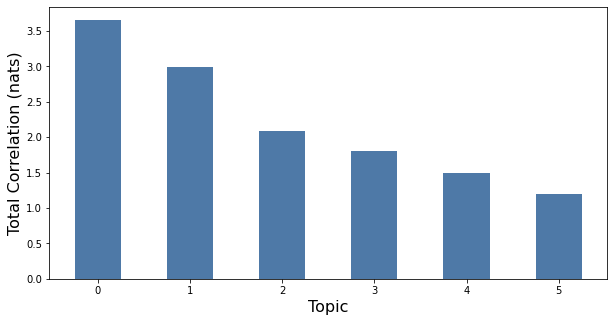

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(anchor_model_agg.tcs.shape[0]), anchor_model_agg.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [120]:
n_docs = 2

topdoclist = []
for i in range(0,len(topics)):
    topdoclist.append(anchor_model_agg.get_top_docs(topic=i, n_docs=n_docs, sort_by="log_prob", print_docs=False))
topdoclist

listtodf = []
k=0
for i in topdoclist:
    placeholder =[]
    for j in i:
        placeholder.append(j[0])
    listtodf.append(placeholder)
    k+=1

topdoc_df = pd.DataFrame(np.array(listtodf).reshape(-1,1))
topdoc_df["topic"] = np.repeat(range(0,len(topics)),n_docs)
pd.merge(topdoc_df, dfagg, how="left", left_on=0, right_on=dfagg.index).rename(columns={0:"Doc#"}).drop(columns=["cleaned", "english_check","tokens"], axis=1)

,Doc#,topic,artist,lyrics
0,0,0,Talib Kweli,",We sell crack to our own out the back of our homes,We smell the musk of the dusk in the crack of the dawn,We go through episodes too, like Attack of the Clones,Work 'til we break our back and you hear the crack of the bone,Just to get by, just to get by, just to get by, just to get by,We commute to computers,Spirits stay mute while you egos spread rumors,We're survivalists turned to consumers,Just to get by, just to get by, just to get by, just to get by,Ask Him why some people got to live in a trailer, cuss like a sailor,I paint a picture with the pen like Norman Mailer,Mi abuela raised three daughters all by herself with no help,I think about her struggle and I find the strength in myself,These words melt in my mouth, they hot like a jail cell in the South,Before my nigga Cor' bailed me out,To get by, just to get by, just to get by, just to get by,We do or die like Bed-Stuy,Through the red sky with the window of the red eye,Let the lead fly, some G. Rap shit, Living to Let Die"
1,5076,0,Royce Da 59,"But you can pray for them,They need you more than me, pray for them,Pray for everybody"
2,4934,1,Royce Da 59,"You're looking at Attila, the psychopathic killer, the caterpillar,Don't tell me when I'm supposed to rap until,Especially when your favorite rapper ain't even half as ill,A savage still, the track's a banana peel, attack of the silverback gorilla,You're havin' a little trouble fathomin' this is actually happenin',Like Anderson Silva back when he snapped his shin in half,And then had the shit hangin' by a flap of skin,After he tried to plant the shit back on the mat again,Pad to pen I’m batty like eyelids when they're blinkin' a lot,You copy me, but you're not,You can't be butterflies, my offsprings are just moths,I see that thing I'ma squash it and rip the wings of it off,So ring the alarm, pull the extinguishers off of the wall,Set the sprinklers off like Jada Pinkett and Queen Latifah,'Till the shingles come off the roof we'll shout at the ceiling,Slaughterhouse in the building, middle fingers aloft,Say what I think when I rhyme, in ink-pen I talk,And the language I speak is my mind,Kingpin and Penguin combined,Spit like it's King of the Dot,A singular thought I think of will help you distinguish apart,The frauds from the cream of the crop,(Wait a minute) Hold up like a flashcard,Damn dawg, is that copyin' or payin' homage?,It's sad because dad taught you to rap as a damn toddler,My dad is your grandfather, I'll have to re-hatch on you,Come back as a black wasp, half yellow jacket, you can't swat a,Sasquatch dancing on top of an ant trample it and stomp it,Smash it and stand on it, dammit, I can't stop it,The rap is a vag' and I'm goin' in like a tampon in this bitch,It's a manslaughter,Stampin' out grasshoppers, you can't be no Rap Gods,In fact you're exact opposites, you make a wack song,And can't hold a candle but even Daniel-san whacks off,You jack-offs need to come to grips like a hand job,The boom bap is coming back with an axe to mumble rap,Lumberjack with a hacksaw,Number one, but my pencils are number twos,'Cause that's all I dos with 'em, poop is my pseudonym,On the john like a prostitute when I'm droppin' a deuce,And when I'm producing them lyrical bowel movements,These beats are like my saloons,'Cause these bars always got my stools in 'em,And I don't need Metamucil to loosen 'em,Bitch, shit is real like I pooped Jerusalem,I'm 'bout to go spin another cocoon,Then I'm cuttin' you from your mother's womb,Then I'm flushin' you!,""Cruising down the river; dancing till your feet got numb; cool summer breezes blowing through your hair as you stood gazing down the river in anticipation of the thrill of the dizzying rides at the amusement park—ah, memories of Bob-Lo Island."",All is your world ain’t nothing but a squirrel tryna get a nut. Just jealous of everybody that’s headed out on that Bob-Lo boat. It is the perfect weather and the perfect time to enjoy a few snacks

### Dictionary building for manual normalization

In [ ]:
list_for_dict = []

for doc in spacyd: 
    for w in doc:
        if w.pos_ == "PROPN":
            list_for_dict.append(str(w).lower())

output = set(list_for_dict)
print(len(list_for_dict))
print(len(output))
outputdf = pd.DataFrame(output)

outputdf.to_csv("output.csv")

### Document-topic clustering

In [ ]:
from sklearn.cluster import KMeans

# Convert DataFrame to matrix
mat = df_doc_topics.values

km = KMeans(n_clusters=3, random_state=4)
km.fit(mat)

# Get cluster assignment labels
df_doc_topic_clusters = df_doc_topics.copy()
df_doc_topic_clusters['Cluster']=km.labels_
df_doc_topic_clusters['Cluster'].value_counts()

In [ ]:
df_clusters = df_doc_topic_clusters.groupby(['Cluster']).median()
df_clusters

In [ ]:
[[num[0] for num in df_clusters.iloc[1].values.reshape(-1, 1).tolist()]]

In [ ]:
from sklearn.metrics import pairwise_distances

top_3_docs = pairwise_distances([[num[0] for num in df_clusters.iloc[1].values.reshape(-1, 1).tolist()]], \
                                df_doc_topics,metric='euclidean').argsort()[0, :3]
df['Cluster']=km.labels_

In [ ]:
df.iloc[top_3_docs[0]]

In [ ]:
df_doc_topics.iloc[top_3_docs[0]]

In [ ]:
df.groupby(['Cluster', 'rating']).count()